### Model class

In [67]:
import sys
import numpy as np
from assimulo.solvers import CVode### Model class### Model class
from assimulo.problem import Explicit_Problem

In [68]:
class Mod1D():
    def __init__(self,N,K,PBC):

        self.T=[1]
        self.pbc=PBC

        #global
        self.n=N
        self.K=K
        self.verb=50
    
        #auxin
        self.Ga=1
        self.A=6
        self.Da=35.5
        self.Da_sym=1
        self.Da_apo=1
        
        #pin
        self.Gp=2
        self.p=40
        self.Ep=1
        
        #phi
        self.m=1.1
        self.mm=1
        
        # extracellular space
        self.Eq=1
        self.q=1
        self.V=10
        
        #molecule X
        self.Gx=1
        self.Dx=1
        self.r=1
    
        
        
    def progress(self,t,T=0):
        T=self.T[0]
        prog="\r{0:.4f}%".format(t/T*100)
        sys.stdout.write(prog+" "*(25-len(prog)))
    
    # shift array    
    def shift(self,arr,d):
        if d: out=np.array(list(arr[1:])+[arr[0]*self.pbc]) # right
        else: out=np.array([arr[-1]*self.pbc]+list(arr[:-1])) # left
        return out
    
    # PIN polarization function    
    def phia(self,aux):
        return aux**self.m
    
    def phix(self,apox):
        return apox**self.mm
    
    def theta(self,aux):
        return (2*aux**self.r)/(self.A**self.r + aux**self.r)
    
    # flux functions 
    def flux_aux(self,aux,apo,pinl,pinr):
        return self.Ep*aux*(pinl+pinr)-self.Eq*self.q*(self.shift(apo,0)+apo)
    
    def flux_apo(self,aux,apo,pinl,pinr):
        return 2*self.Eq*self.q*apo-self.Ep*(pinr*aux+self.shift(pinl,1)*self.shift(aux,1))
    
    # diffusion functions  
    def diff(self,aux,apo):
        return self.Da*(self.shift(apo,0)+apo-2*aux)
    
    def apodiff(self,aux,apo):
        return self.Da*(self.shift(aux,1)+aux-2*apo)
        
    def cytxdiff(self,cytx,apox):
        return self.Dx*(self.shift(apox,0)+apox-2*cytx)
    
    def apoxdiff(self,cytx,apox):
        return self.Dx*(self.shift(cytx,1)+cytx-2*apox)
    
        # symplast duffusion
    def sym_diff(self,aux):
        return self.Da_sym*(self.shift(aux,0)+self.shift(aux,1)-2*aux)
    
        # apoplast diffusion
    def apo_diff(self,apo):
        return (self.Da_apo/self.V)*(self.shift(apo,0)+self.shift(apo,1)-2*apo)

    # ODE 
    def sim(self,time,start):
        
        # progress of integration
        self.progress(time)

        aux,apo,pinl,pinr,cytx,apox=np.array_split(start,6)

        dta=self.Ga*(self.A-aux)-self.flux_aux(aux,apo,pinl,pinr)+self.diff(aux,apo)+self.sym_diff(aux)
        dtapo=-self.flux_apo(aux,apo,pinl,pinr)/self.V+self.apodiff(aux,apo)/self.V+self.apo_diff(apo)
        dtpl=self.Gp*(self.p*(self.phix(self.shift(apox,0))/(self.phix(self.shift(apox,0))+self.phix(apox)))-pinl)
        dtpr=self.Gp*(self.p*(self.phix(apox)/(self.phix(self.shift(apox,0))+self.phix(apox)))-pinr)
        
        dtcx=self.Gx*(self.theta(aux)-cytx)+self.cytxdiff(cytx,apox)
        dtax=-self.Gx*apox+self.apoxdiff(cytx,apox)/self.V

        out=np.concatenate((dta,dtapo,dtpl,dtpr,dtcx,dtax))
        return out
    
    def intgr(self,time,start):
        self.T[0]=time
        
        # CVode from Assimulo                
        problem=Explicit_Problem(self.sim,start)
        sim=CVode(problem)
        sim.verbosity=self.verb
        T,res=sim.simulate(time,time)

        return [T,res]    

### Execute model

In [69]:
### Execute modelimport sys
import numpy as np
import pylab as plt

In [118]:
# cell number
n=100

# neighbour number
k=2

# base auxin, PIN and molecule X concentration
auxin=6
pin=4
X=2
aX=.2

# integration time
time=10000


# noise on base concentration [%]
noise=.0

# initial values
# np.random.seed(123)
aux = [auxin for i in range(n)] + np.random.normal(0,auxin*noise,n)
apo = [auxin for i in range(n)] + np.random.normal(0,auxin*noise,n)
pin_left = [pin for i in range(n)] + np.random.normal(0,pin*noise,n)
pin_right = [2*pin-x for x in pin_left] + np.random.normal(0,pin*noise,n)

cytx=[X for i in range(n)] + np.random.normal(0,X*noise,n)
apox=[aX for i in range(n)] + np.random.normal(0,aX*noise,n)

#set initial distribution manually (noise=0)
# i.e. aux[30]*=1.1

start=np.concatenate((aux, apo, pin_left, pin_right, cytx, apox))

# periodic boundary condition
PBC=0

In [123]:
# class initiation
model=Mod1D(n,k,PBC)

# model.Ga=1 # auxin degredation/synthesis coefficient to A
# model.A=6 # auxin base level of synthesis (steady state)
# model.Da=35.5 # auxin diffusion coefficient to equilibrium
model.Ga=.2 # auxin degredation/synthesis coefficient to A
model.A=1 # auxin base level of synthesis (steady state)
model.Da=1 # auxin diffusion coefficient to equilibrium
model.Da_sym=0 # symplast diffusion coefficient (cell-cell)
model.Da_apo=0 # apoplast diffusion coefficient (apoplast-apoplast)

# model.Gp=2 # pin degredation/synthesis coefficient to p
# model.p=40 # pin base level of synthesis (steady state)
# model.m=4 # influence of regulatory function phi
# model.Ep=1 # pin efflux efficiency
model.Gp=1 # pin degredation/synthesis coefficient to p
model.p=10 # pin base level of synthesis (steady state)
model.m=4 # value of regulatory function phi
model.Ep=1 # pin efflux efficiency

# model.q=10 # concentration of influx carriert on membrane side
# model.Eq=1 # efficiency of influx carrier
# model.V=1 # volume ratio of apoplast to cytoplast
model.q=10 # concentration of influx carriert on membrane side
model.Eq=1 # efficiency of influx carrier
model.V=1 # volume ratio of apoplast to cytoplast

model.Gx=1 # molecule X degredation/synthesis coefficient 
model.Dx=10 # molecule X diffusion coefficient
model.r=1 # value of regulatory function theta
model.mm=6 # phi with molecule x

In [124]:
# integration
T,R=model.intgr(time,start)

0.0000%                 

100.0000%               

In [125]:
# find steady state
def steady(thr,acc):
    state0=R[0,:n]
    window=0
    for i in range(len(R)):
        if window==thr: return i
        if (state0-R[i,:n]<=acc).all(): window+=1
        else: window=0
        state0=R[i,:n]
    return "NO"

        
steady(thr=100,acc=10**-4)

892

### Create plots

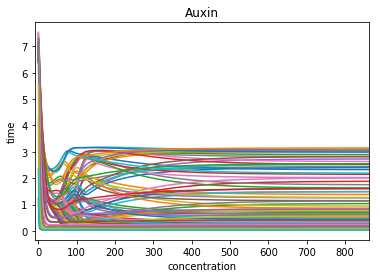

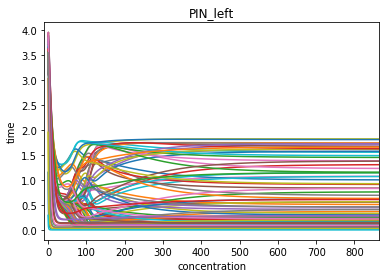

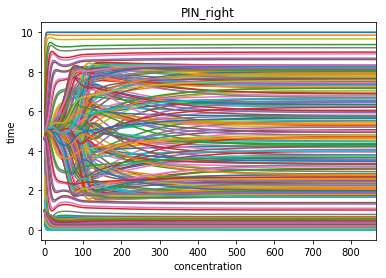

In [83]:
# concentration of auxin and PINs (both side) over time
def CT(show="100",showrange=[(0,T[-1]),(0,T[-1]),(0,T[-1])]):
    
    if show[0]=="1":
        plt.plot(range(time),R[1:,:n])
        plt.title("Auxin")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[0]))
        plt.show()
    
    if show[1]=="1":### Create plots
        plt.plot(range(time),R[1:,n:2*n])
        plt.title("PIN_left")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[1]))
        plt.show()
    
    if show[2]=="1":
        plt.plot(range(time),R[1:,2*n:])
        plt.title("PIN_right")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[2]))
        plt.show()

xstart=-10        
xend=steady(thr=100,acc=10**-4)+10

CT(show="111",showrange=[(xstart,xend),(xstart,xend),(xstart,xend)])

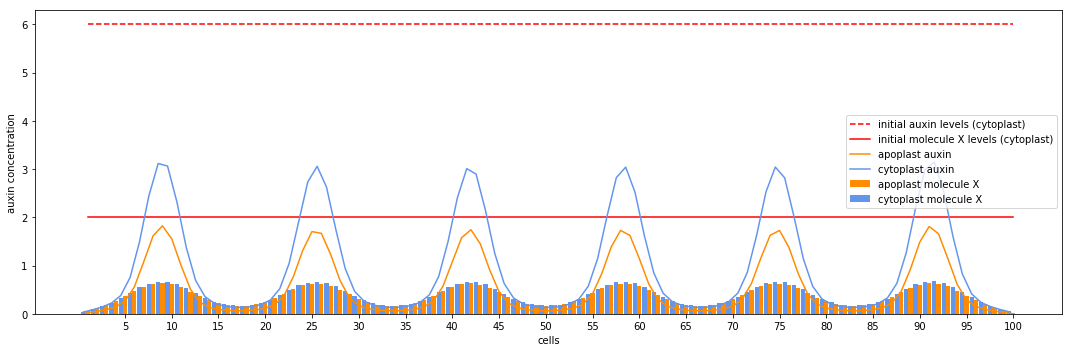

In [126]:
# concentration of auxin in cytosol and apoplast over all cells
# lines: show curve plot; bars: show barplot
def molX(lines,bars):
    
    fig=plt.figure(figsize=(15,5))
    ax=plt.subplot(111)
    ind=np.arange(1,n+1)
    bw=0.45
    
    plt.plot(range(1,n+1),R[0,:n],"--",color="r",label="initial auxin levels (cytoplast)")
    plt.plot(range(1,n+1),R[0,4*n:5*n],color="r",label="initial molecule X levels (cytoplast)")
    if bars:
        ax.bar(ind,R[-1,5*n:],bw,label="apoplast molecule X",color="darkorange")
        ax.bar(ind-bw,R[-1,4*n:5*n],bw,label="cytoplast molecule X",color="cornflowerblue")
    if lines:
        ax.plot(ind,R[-1,n:2*n],label="apoplast auxin",color="darkorange")
        ax.plot(ind-bw,R[-1,:n],label="cytoplast auxin",color="cornflowerblue")
        
    ax.set_xticks([int(ind[i-1]+bw) for i in range(1,n+1) if i%5==0])
    plt.xlabel("cells")
    plt.ylabel("auxin concentration")
    plt.legend()
    fig.tight_layout()
    plt.show()

molX(lines=1,bars=1)

max: 3.144
min: 0.037


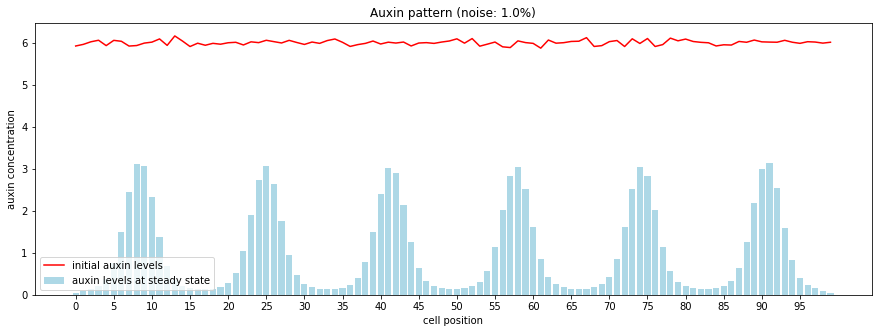

In [77]:
# barplot of auxin levels over all cells without apoplast (base: show initial auxin distribution)
def pattern(base):

    print("max:","{0:.3f}".format(max(R[-1,:n])))
    print("min:","{0:.3f}".format(min(R[-1,:n])))
    
    fig=plt.figure(figsize=(15,5))
    
    plt.bar(range(n),R[-1,:n],color="lightblue",label="auxin levels at steady state")
    if base: plt.plot(range(n),start[:n],"r",label="initial auxin levels")
        
    plt.ylabel("auxin concentration")
    plt.xlabel("cell position")
    if n>50: plt.xticks(range(0,n,5))
    else: plt.xticks(range(1,n+1))
    plt.title("Auxin pattern (noise: {}%)".format(noise*100))
    plt.legend(loc="lower left")
    plt.show()
    
pattern(base=1)

In [22]:
# progress of integration (timestep/total time)
def progress(t,T):
    prog="\r{0:.4f}%".format(t/T*100)
    sys.stdout.write(prog+" "*(25-len(prog)))

### Create animated plots

In [94]:
import numpy as np
import pylab as plt### Create animated plot
from matplotlib import animation
from IPython.display import HTML

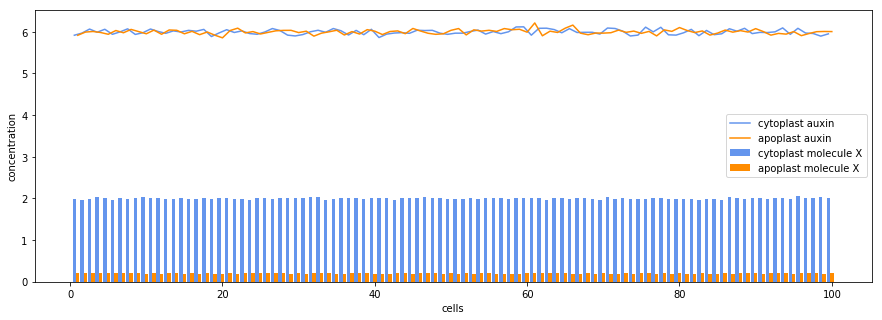

In [96]:
fig=plt.figure(figsize=(15,5))
ax=plt.axes()
#ax2=ax.twinx()

ax.set_xlabel("cells")
ax.set_ylabel("concentration")
#ax.set_ylim((0,3.5))
#ax2.set_ylabel("PIN concentration")
#ax2.set_ylim((0,100))

ind=np.arange(1,n+1)
bw=0.45

barA = ax.bar(ind-bw,R[0,4*n:5*n],bw,label="cytoplast molecule X",color="cornflowerblue")
barB = ax.bar(ind,R[0,5*n:],bw,label="apoplast molecule X",color="darkorange")
lineA, = ax.plot(ind-bw,R[0,:n],label="cytoplast auxin",color="cornflowerblue")
lineB, = ax.plot(ind,R[0,n:2*n],label="apoplast auxin",color="darkorange")

ax.legend()

In [97]:
def animate(i,pin=1):
    for j in range(n):
        [barA[j].set_height(R[i,j+4*n]) for j in range(n)]
        [barB[j].set_height(R[i,j+5*n]) for j in range(n)]
    if pin:
        lineA.set_data(ind-bw,R[i,:n])
        lineB.set_data(ind,R[i,n:2*n])
    ax.set_title("t="+str(i))
    return barA,barB,lineA,lineB

In [98]:
ani=animation.FuncAnimation(fig,animate,frames=200)#steady(thr=100,acc=10**-4)

In [99]:
HTML(ani.to_html5_video())

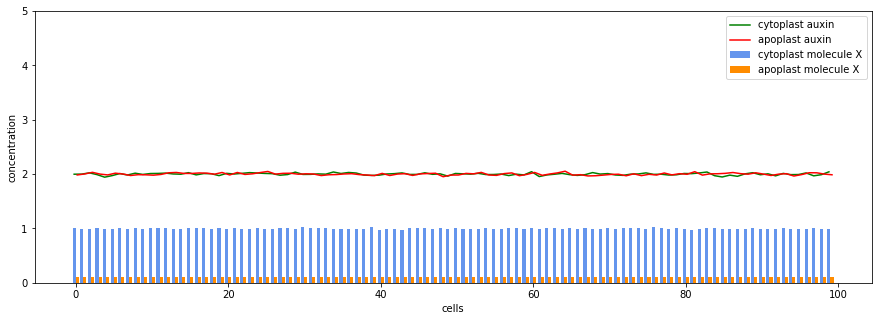

In [54]:
fig2=plt.figure(figsize=(15,5))
ax=plt.axes()

ax.set_xlabel("cells")
ax.set_ylabel("concentration")
ax.set_ylim((0,5))

barXc = ax.bar(np.arange(n)-.2,R[0,4*n:5*n],width=0.4,align="center",color="cornflowerblue",label="cytoplast molecule X")
barXa = ax.bar(np.arange(n)+.2,R[0,5*n:],width=0.4,align="center",color="darkorange",label="apoplast molecule X")
aux, = ax.plot(np.arange(n)-.2,R[0,:n],color="green",label="cytoplast auxin")
apo, = ax.plot(np.arange(n)+.2,R[0,n:2*n],color="red",label="apoplast auxin")

ax.legend()

In [55]:
def animate2(i):
    for j in range(n):
        [barXc[j].set_height(R[i,4*n+j]) for j in range(n)]
        [barXa[j].set_height(R[i,5*n+j]) for j in range(n)]  
    aux.set_data(range(n),R[i,:n])
    apo.set_data(range(n),R[i,n:2*n])
    ax.set_title("t="+str(i))
    return barXc,barXa

In [56]:
ani2=animation.FuncAnimation(fig2,animate2,frames=200)

In [57]:
HTML(ani2.to_html5_video())